# Visual QA, Coeus
<center><img src='https://imgur.com/vpMkNww.jpg'></center>
Project for the deep learning course 2021/2022 held by professor Fabrizio Silvestri. 

Since the choosen task is about **Visual Question Answering** we've picked a mythical and distinctive name for the project, ***COEUS***. 


> ⚡ In Greek mythology, Coeus (*from Ancient Greek: Κοῖος, Koios, "query, questioning" or "intelligence"*)  was one of the Titans.

**VQA** is in general a very challenging task since it requires an understanding of vision, language and commonsense knowledge to answer a given question. The aim of the method is in fact related to the connection between a given image and a question about it; the model should be able to correctly answer the question.  

Just to get a better feeling of what is our goal here follow some examples:<br>
![](https://i.imgur.com/M0Hrqer.png)



## Colab integration

We produced the code using a *local environment* in **vscode**. To make it works with colab, after cloning the github repository, we also had to:
* reduce the size of the dataset (***10000 ➡ 6800*** (*train set*) and ***1000 ➡ 700*** (*validation set*), or we must buy colab-pro for higher ram.  
* reduce the number of workers (***8 ➡ 2***).
* remove the "*pin memory*" property of the dataloader (***True ➡ False***). 

> *If you want to reproduce our exact scores, you should set at least the original dataset sizes.*

> To download all models and datasets it takes ~15/20 mins, we advice to go through the notebook meanwhile.

In [1]:
local_project = True
# set this variable to true if you want to download the complete
# dataset ~20GB, we are using only a small portion of it
download_all = False
if not local_project:
    !git clone https://github.com/DennisRotondi/Visual_QA_deep_learning
    !pip3 install -r Visual_QA_deep_learning/requirements.txt
    %cd Visual_QA_deep_learning/models
    # download our trained models
    !bash download_models.sh
    %cd ../datasets
    # download the official dataset
    if download_all:
      !bash download_dataset.sh
    else:
      !bash download_partial_data.sh
    !rm *.zip
    # we restart the runtime to load the new libraries
    exit()

In [1]:
# after exiting the runtime is roloaded and we need to re-define this variable
local_project = True
# this is the last thing to do, it allows to
# have coherent relative paths wrt the local env
%cd Visual_QA_deep_learning

[Errno 2] No such file or directory: 'Visual_QA_deep_learning'
/home/dennis/Desktop/Visual_QA_deep_learning


## Import and reproducibility stuff

In [2]:
import copy
import csv
import datetime
import gc
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
import random
import re
import torch
import torch.nn.functional as F
from PIL import Image
from collections import OrderedDict, Counter
from dataclasses import dataclass, asdict
from os import path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import ViltProcessor, ViltForQuestionAnswering, ViltModel
from typing import Tuple, List, Any, Dict, Optional
# to avoid deadlock at traning time for the tokenizer
os.environ['TOKENIZERS_PARALLELISM'] = "false"
# it's important to have reproducible experiment,
# to this purpose we seeded everything is seedable
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
# Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)

Global seed set to 0


## Data Preprocessing


> The first step is to ***read*** the dataset.


We're using *Visual Question Answering* (***VQA***) ***v2.0***: a dataset that contains open-ended questions about images. <br> It consists of:

* **265,016** images (COCO and abstract scenes)
* At least 3 questions (**5.4** questions on average) per image.
* **10** ground truth answers per question
* **3** plausible (but likely incorrect) answers per question.
* Automatic evaluation metric.

> The second step is to ***preprocess*** the dataset. Questions and answers have been processed accordingly to the following rules:



*   Making all characters **lowercase**;
*   **Removing periods** except if it occurs as decimal;
*   **Converting** number words to **digits**;
*   **Removing articles** (*a*, *an*, *the*);
*   Adding apostrophe if a **contraction** is missing it (e.g., convert *”dont”* to *”don’t”*);
*   Replacing all **punctuation** (except *apostrophe* and *colon*) with a *space* character.


> *Note that those steps are required at evaluation time to compute the correct metric!*



In [3]:
# this code comes partially from the original implementation 
# https://github.com/GT-Vision-Lab/VQA, it helps in reading the 
# json files from the dataset and creating a class to quickly 
# retrieve the annotations of each <question, image> pair. Here
# we also perform the preprocessing needed for evaluation, these
# changes affect the vocabularies (using more advanced embeddings
# like bert-uncased is very useful to have "uncased" words for example),
class VQA:
	def __init__(self, annotations_file: str, questions_file: str, 
				images_semi_path: str, remove_mult_ans: bool, limit_size: int):
		self.proprocess_init()
		# we load the answer and the question json file
		dataset = json.load(open(annotations_file, 'r'))
		questions = json.load(open(questions_file, 'r'))
		# 'qa' and 'qqa' will be the dictionaries where the 
		# output of the preprocessing step will be saved!
		qa = dict()
		qqa = dict()
		# total number of questions
		self.n_tot = 0
		# number of answers with more than a word
		self.n_mul = 0
		# counter for the length of each answer, to understand if a baseline that
		#  produce one-word ans is feasible
		self.c_len = Counter()
		###### PREPROCESSING ######
		for ann in dataset['annotations']:
			self.n_tot += 1
			if self.n_tot > limit_size:
				break
			qid = ann['question_id']
			qatmp = ann
			qatmp["multiple_choice_answer"] = self.preprocess(
				qatmp["multiple_choice_answer"])
			ln = len(qatmp["multiple_choice_answer"].split())
			self.c_len.update([ln])
			if ln > 1:
				self.n_mul += 1
				if remove_mult_ans:
					continue
			qa[qid] = qatmp
			for i in range(10):
				qa[qid]["answers"][i]["answer"] = self.preprocess(
					qa[qid]["answers"][i]["answer"])
		for ques in questions['questions']:
			qid = ques['question_id']
			if qa.get(qid, "N") == "N":
				continue
			qqa[qid] = ques
			qqa[qid]["question"] = self.preprocess(qqa[qid]["question"])
		###########################
		self.qa = qa
		self.qqa = qqa
		self.images_semi_path = images_semi_path

	def get_img_from_id(self, img_id):
		ids = str(img_id)
		# small trick to retrive the path from the id
		return self.images_semi_path+"0"*(12-len(ids))+ids+".jpg"
	# this function just set the utilities for the preprocessing
	def proprocess_init(self):
		self.contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't",
							"couldve": "could've", "couldnt": "couldn't",
							"couldn'tve": "couldn't've", "couldnt've": "couldn't've",
							"didnt": "didn't", "doesnt": "doesn't", "dont": "don't",
							"hadnt": "hadn't", "hadnt've": "hadn't've",
							"hadn'tve": "hadn't've", "hasnt": "hasn't",
							"havent": "haven't", "hed": "he'd", "hed've": "he'd've",
							"he'dve": "he'd've", "hes": "he's", "howd": "how'd",
							"howll": "how'll", "hows": "how's", "Id've": "I'd've",
							"I'dve": "I'd've", "Im": "I'm", "Ive": "I've",
							"isnt": "isn't", "itd": "it'd", "itd've": "it'd've",
							"it'dve": "it'd've", "itll": "it'll", "let's": "let's",
							"maam": "ma'am", "mightnt": "mightn't",
							"mightnt've": "mightn't've", "mightn'tve": "mightn't've",
							"mightve": "might've", "mustnt": "mustn't",
							"mustve": "must've", "neednt": "needn't",
							"notve": "not've", "oclock": "o'clock",
							"oughtnt": "oughtn't", "ow's'at": "'ow's'at",
							"'ows'at": "'ow's'at", "'ow'sat": "'ow's'at",
							"shant": "shan't", "shed've": "she'd've",
							"she'dve": "she'd've", "she's": "she's",
							"shouldve": "should've", "shouldnt": "shouldn't",
							"shouldnt've": "shouldn't've",
							"shouldn'tve": "shouldn't've", "somebody'd": "somebodyd",
							"somebodyd've": "somebody'd've",
							"somebody'dve": "somebody'd've",
							"somebodyll": "somebody'll", "somebodys": "somebody's",
							"someoned": "someone'd", "someoned've": "someone'd've",
							"someone'dve": "someone'd've", "someonell": "someone'll",
							"someones": "someone's", "somethingd": "something'd",
							"somethingd've": "something'd've",
							"something'dve": "something'd've",
							"somethingll": "something'll", "thats": "that's",
							"thered": "there'd", "thered've": "there'd've",
							"there'dve": "there'd've", "therere": "there're",
							"theres": "there's", "theyd": "they'd",
							"theyd've": "they'd've", "they'dve": "they'd've",
							"theyll": "they'll", "theyre": "they're",
							"theyve": "they've", "twas": "'twas", "wasnt": "wasn't",
							"wed've": "we'd've", "we'dve": "we'd've",
							"weve": "we've", "werent": "weren't", "whatll":
							"what'll", "whatre": "what're", "whats": "what's",
							"whatve": "what've", "whens": "when's",
							"whered": "where'd", "wheres": "where's",
							"whereve": "where've", "whod": "who'd",
							"whod've": "who'd've", "who'dve": "who'd've",
							"wholl": "who'll", "whos": "who's", "whove": "who've",
							"whyll": "why'll", "whyre": "why're", "whys": "why's",
							"wont": "won't", "wouldve": "would've",
							"wouldnt": "wouldn't", "wouldnt've": "wouldn't've",
							"wouldn'tve": "wouldn't've", "yall": "y'all",
							"yall'll": "y'all'll", "y'allll": "y'all'll",
							"yall'd've": "y'all'd've", "y'alld've": "y'all'd've",
							"y'all'dve": "y'all'd've", "youd": "you'd",
							"youd've": "you'd've", "you'dve": "you'd've",
							"youll": "you'll", "youre": "you're", "youve": "you've"}
		self.manualMap = {'none': '0',
					'zero': '0',
					'one': '1',
					'two': '2',
					'three': '3',
					'four': '4',
					'five': '5',
					'six': '6',
					'seven': '7',
					'eight': '8',
					'nine': '9',
					'ten': '10'
					}
		self.articles = ['a', 'an', 'the']
		self.periodStrip = re.compile("(?!<=\d)(\.)(?!\d)")
		self.commaStrip = re.compile("(\d)(\,)(\d)")
		self.punct = [';', r"/", '[', ']', '"', '{', '}',
				'(', ')', '=', '+', '\\', '_', '-',
				'>', '<', '@', '`', ',', '?', '!']

	def preprocess(self, sentence):
		sentence = sentence.lower()
		sentence = sentence.replace('\n', ' ')
		sentence = sentence.replace('\t', ' ')
		sentence = sentence.strip()
		ls = sentence.split()
		ws = []
		for w in ls:
			w = self.processPunctuation(w)
			w = self.processDigitArticle(w)
			ws += [w]
		return " ".join(ws)

	def processPunctuation(self, inText):
		outText = inText
		for p in self.punct:
			if (p + ' ' in inText or ' ' + p in inText) or (re.search(self.commaStrip, 
			                                                          inText) != None):
				outText = outText.replace(p, '')
			else:
				outText = outText.replace(p, ' ')
		outText = self.periodStrip.sub("",
									outText,
									re.UNICODE)
		return outText

	def processDigitArticle(self, inText):
		outText = []
		tempText = inText.lower().split()
		for word in tempText:
			word = self.manualMap.setdefault(word, word)
			if word not in self.articles:
				outText.append(word)
			else:
				pass
		for wordId, word in enumerate(outText):
			if word in self.contractions:
				outText[wordId] = self.contractions[word]
		outText = ' '.join(outText)
		return outText

# Input json files for the VQA class
annotations_file = "datasets/v2_mscoco_train2014_annotations.json"
questions_file = "datasets/v2_OpenEnded_mscoco_train2014_questions.json"
images_semi_path = "datasets/train2014/COCO_train2014_"  # 000000000009.jpg
# We give as input the semi path to the train images:
# in this way we are able to easily retrieve the images thanks to the class 
# function "get_img_from_id" NOTE: we cannot use the whole dataset as it is
# with our limited hardware, therefore we limited ourselves fixing a size
# of 10000 samples (on the local probject).
train_VQA = VQA(annotations_file, questions_file,
                images_semi_path, remove_mult_ans=True, limit_size=10000)
# We also require to load the validation annotations and images, it will 
# be useful later to test our models. NOTE: here we can't remove "mult_ans"
# since it would be like cheating during the evaluation
annotations_file_val = "datasets/v2_mscoco_val2014_annotations.json"
questions_file_val = "datasets/v2_OpenEnded_mscoco_val2014_questions.json"
images_semi_path_val = "datasets/val2014/COCO_val2014_"
val_VQA = VQA(annotations_file_val, questions_file_val,
              images_semi_path_val, remove_mult_ans=False, limit_size=1000)

### View data




> Let's ***visualize*** the structure of our data, it would be useful to access correctly the different fields.



#### Answer sample

In [4]:
# For example for the question id '309002'
train_VQA.qa[309002]

{'question_type': 'what animal is',
 'multiple_choice_answer': 'dog',
 'answers': [{'answer': 'bear', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'bear', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'dog', 'answer_confidence': 'maybe', 'answer_id': 5},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'teddy bear', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 309,
 'answer_type': 'other',
 'question_id': 309002}

#### Question sample

In [5]:
# For example for the question id '309002'
train_VQA.qqa[309002]

{'image_id': 309, 'question': 'what animal is shown', 'question_id': 309002}

#### Image + question + answer

*The complete sample needed for our Visual QA task.*

QUESTION ID: 131366000

datasets/train2014/COCO_train2014_000000131366.jpg



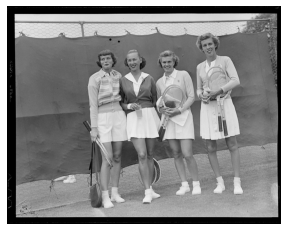

QUESTION
how many people are standing next to each other
MOST COMMON ANSWER
4


In [6]:
# let's see if it works
q = 131366000
print("QUESTION ID: {}".format(q))
print()
img_id = train_VQA.qqa[q]["image_id"]
img_pth = train_VQA.get_img_from_id(img_id)
print(img_pth)
print()

img = Image.open(img_pth).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()
print("QUESTION")
print(train_VQA.qqa[q]["question"])
print("MOST COMMON ANSWER")
print(train_VQA.qa[q]["multiple_choice_answer"])


### Vocabulary
We need a data structure to encode and decode the words we are going to feed up our Deep Learning Model, this structure is the ***vocabulary*** under the form of a *python dictionary*.
We've built a vocabulary of size **1000** with two extra tokens which are used for: **OOV** (*out of vocabulary*) and **padding** (to have the same tensor size at training time for the neural network) both for *questions* and *answers*.

In [7]:
# Let's make the vocabs
qst_v = Counter()
ans_v = Counter()

for k in train_VQA.qa:
    qst_v.update(train_VQA.qqa[k]["question"].split())
    ans_v.update(train_VQA.qa[k]["multiple_choice_answer"].split())

# We print the most common words
print("10 most common words for questions: ")
print(qst_v.most_common(10))
print()
print("10 most common words for answers: ")
print(ans_v.most_common(10))
print()


def build_vocab(counter, size):
    w2id = {}
    id2w = {}
    for idx, (i, _) in enumerate(counter.most_common(size)):
        w2id[i] = idx
        id2w[idx] = i
    w2id["OOV"] = idx+1
    id2w[idx+1] = "OOV"
    w2id["PAD"] = idx+2
    id2w[idx+2] = "PAD"
    return w2id, id2w


# We set the vocabularies size as in the paper
qv_size = 1000
av_size = 1000

qv_w2id, qv_id2w = build_vocab(qst_v, qv_size)
av_w2id, av_id2w = build_vocab(ans_v, av_size)

# Show the results
print("Key of the word 'blue' is --> {}".format(av_w2id["blue"]))
print("Word of the key '7' is obviously --> {}".format(av_id2w[7]))
print()
# OOV and PAD
print("Where are the special tokens?")
print("Word in position 1000 --> {}".format(av_id2w[1000]))
print("Word in position 1001 --> {}".format(av_id2w[1001]))

10 most common words for questions: 
[('is', 5730), ('what', 3761), ('are', 2264), ('this', 1817), ('in', 1460), ('on', 1336), ('of', 1222), ('how', 1174), ('many', 1117), ('color', 1017)]

10 most common words for answers: 
[('yes', 1930), ('no', 1761), ('1', 282), ('2', 241), ('white', 187), ('3', 170), ('0', 151), ('blue', 135), ('black', 135), ('red', 125)]

Key of the word 'blue' is --> 7
Word of the key '7' is obviously --> blue

Where are the special tokens?
Word in position 1000 --> OOV
Word in position 1001 --> PAD


## Dataset statistics

We want to do some research on the *statistics* of our dataset, in particular we're interested in:

1.   Percentage of **number of words** for all the answers.
2.   Count of the *most predominant* words in **questions**.
3.   Count of the *most predominant *words in **answers**.
4.   Percentage of **words** used in *answers* and *questions* that are in the *vocabulary*.



> 💡 Two of this results are particularly interesting for the choices we made. 
Following *result 1* we discovered that only **8%** of the answers have more then one word, thus we only kept the answers with one word.
*Statistic 4* is also very interesting since it shows that around **85%** of questions and answers are whithin our vocabulary, so the size 1000 is perfectly fine.


In [8]:
def one_group_bar(columns, data, title, percentage=True):
  labels = columns
  data = data[0]
  color_list = []
  for _ in range(len(data)):
    color = [random.randrange(0, 1)/255,
             random.randrange(0, 255)/255, random.randrange(0, 255)/255, 1]
    color_list.append(color)
  x = np.arange(len(labels))
  width = 0.5  # the width of the bars
  fig, ax = plt.subplots(figsize=(12, 5), layout='constrained')
  rects = ax.bar(x, data, width, color=color_list)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_title(title)
  ax.set_xticks(x, labels)
  if percentage:
    rects_labels = [('%.2f' % i) + "%" for i in data]
  else:
    rects_labels = data
  ax.bar_label(rects, rects_labels, padding=3)

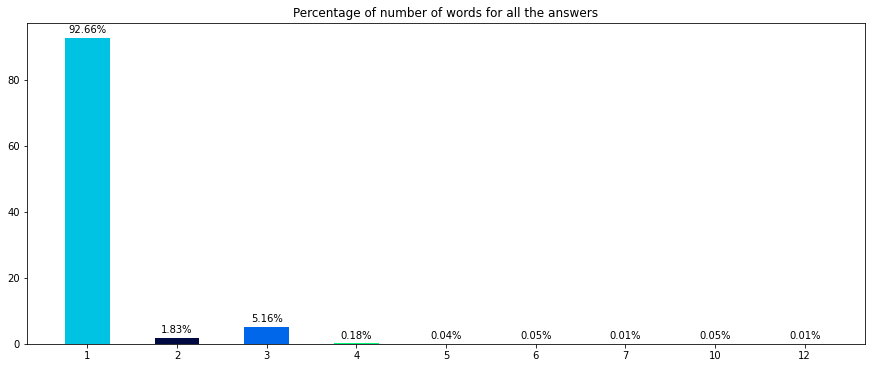

In [9]:
total_number_questions = train_VQA.n_tot
number_questions_pI_word = train_VQA.n_mul
number_questions_one_word = total_number_questions - number_questions_pI_word
## 1: Percentage of number of words for all the answers
columns = sorted([e+1 for e in list(train_VQA.c_len.keys())])
table_data = list(train_VQA.c_len.values())
table_data_percentage = []
table_data_percentage.append(
    [(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(
    columns, table_data_percentage,
    "Percentage of number of words for all the answers")


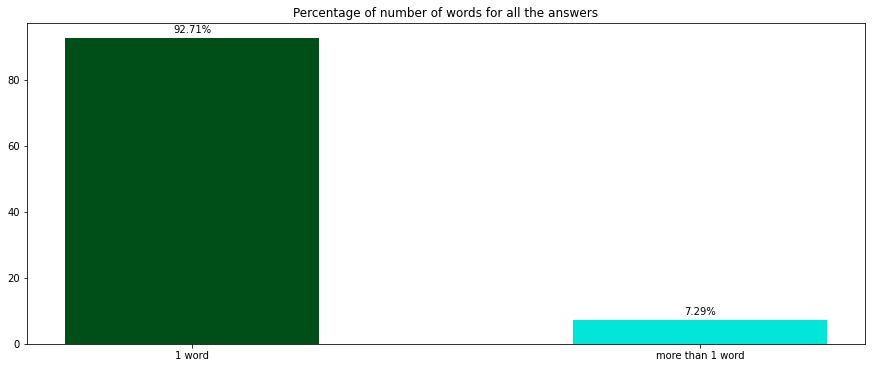

In [10]:
## 2: Percentage of number of words for all the answers
columns = ["1 word", "more than 1 word"]
table_data = [number_questions_one_word, number_questions_pI_word]
table_data_percentage = []
table_data_percentage.append(
    [(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, table_data_percentage,
              "Percentage of number of words for all the answers")


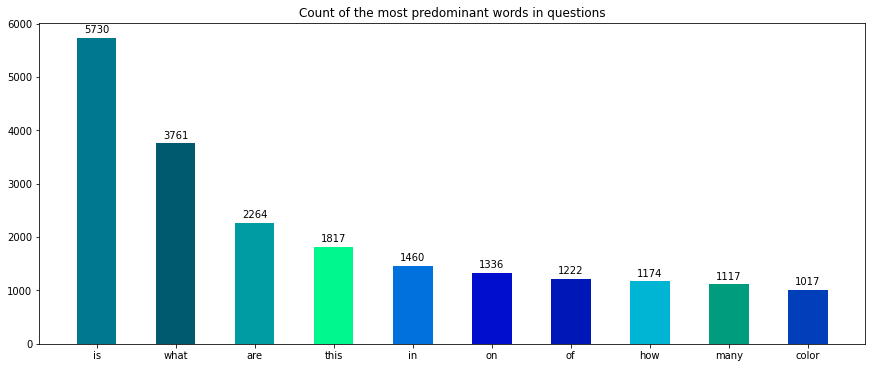

In [11]:
## 3: Count of the most predominant words in questions
q_most_common_words = qst_v.most_common(10)
columns = [e[0] for e in q_most_common_words]
table_data = [e[1] for e in q_most_common_words]
one_group_bar(
    columns, [table_data],
    "Count of the most predominant words in questions", False)


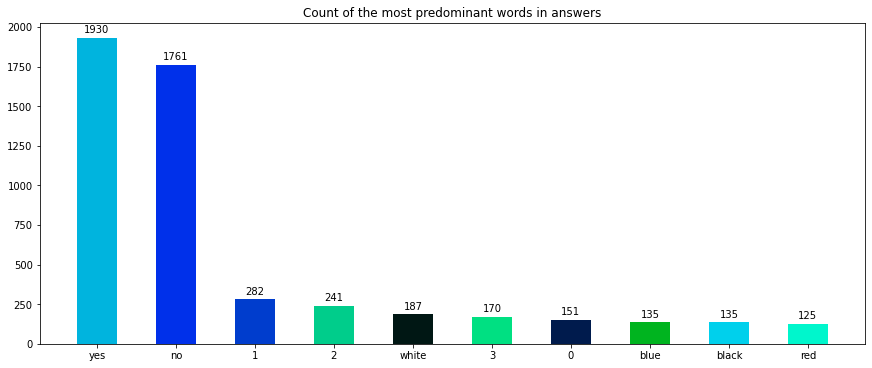

In [12]:
## 4: Count of the most predominant words in answers
a_most_common_words = ans_v.most_common(10)
columns = [e[0] for e in a_most_common_words]
table_data = [e[1] for e in a_most_common_words]
table_data_percentage = []
table_data_percentage.append(
    [(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(
    columns, [table_data],
    "Count of the most predominant words in answers", False)


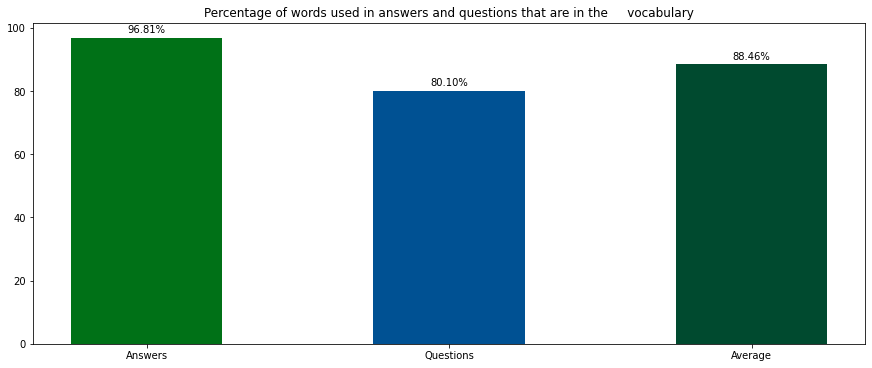

In [13]:
## 5: Percentage of words used in answers and questions that are in the vocab
l = [e[0] for e in ans_v.most_common(1000)]
number_words_in_most_common_ans = 0
for (_, ann) in list(train_VQA.qa.items()):
  if ann["multiple_choice_answer"] in l:
    number_words_in_most_common_ans += 1
l = [e[0] for e in qst_v.most_common(1000)]
number_words_in_most_common_qst = 0
total_number_words = 0
list(train_VQA.qqa.items())
for (_, qst) in list(train_VQA.qqa.items()):
  for w in qst["question"].split(" "):
    total_number_words += 1
    if w in l:
      number_words_in_most_common_qst += 1
column = ["Answers", "Questions", "Average"]
table_data = [number_words_in_most_common_ans, number_words_in_most_common_qst]
ans_value = number_words_in_most_common_ans/len(train_VQA.qa)
qst_value = number_words_in_most_common_qst/total_number_words
avg_v = (ans_value + qst_value) / 2
table_data_percentage = [ans_value*100, qst_value*100, avg_v*100]
one_group_bar(
    column, [table_data_percentage],
    "Percentage of words used in answers and questions that are in the\
     vocabulary")

## Utilities

*Definition of some utility functions we're going  to use across the notebook.*

In [14]:
# this function implements the requested metric to evaluate our model
def evaluate_performances(
        model, data, on_train_set: bool, need_device: bool = True,
        intermediate=False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    # decode utility
    av_id2w = data.av_id2w
    it_data = iter(dataset)
    ans_types = Counter()
    scores = dict()
    for batch in tqdm(it_data):
        if need_device:
            batch["question"] = batch["question"].to(device)
            batch["img"] = batch["img"].to(device)
        elif intermediate:
            batch["question"] = batch["question"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"], pred["pred"]):
            ann = vqa.qa[id]
            ans_types.update([ann["answer_type"]])
            score = 0
            pred_ans = av_id2w.get(pred)
            for ans in ann["answers"]:
                answer = ans["answer"]
                if answer == pred_ans:
                    score += 1
                    # just for efficiency reasons
                    if score > 2:
                        break
            scores[ann["answer_type"]] = scores.get(
                ann["answer_type"], 0) + min([score/3, 1])
    # print the final statisics
    print("There are: (type, number)")
    tot_q = 0
    tot_s = 0
    for k in ans_types:
        tot_q += ans_types[k]
        print(k+" "+str(ans_types[k]))
        tot_s += scores[k]
        print("with score: "+str(scores[k]/ans_types[k]))
    print("Final score: "+str(tot_s/tot_q))
    return ans_types, scores


In [15]:
# this function allows to show the prediction
# on a list of ids taken from the train/dev set
def print_item_pred(data, model, ids: list, on_train_set: bool,
                    need_device: bool = True):
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    it_data = iter(dataset)
    av_id2w = data.av_id2w
    for batch in it_data:
        if len(ids) == 0:
            break
        if need_device:
            batch["question"] = batch["question"].to(device)
            batch["img"] = batch["img"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"], pred["pred"]):
            if id in ids:
                ids.remove(id)
                question = vqa.qqa[id]["question"]
                answer = vqa.qa[id]["multiple_choice_answer"]
                img_id = vqa.qqa[id]["image_id"]
                img_pth = vqa.get_img_from_id(img_id)
                img = Image.open(img_pth).convert('RGB')
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                print("QUESTION")
                print(question)
                print("MOST COMMON ANSWER")
                print(answer)
                print("PREDICTED ANSWER")
                print(av_id2w.get(pred))


In [16]:
# this function is very helpful and allows to
# compare a list of models on a list of chosen metrics
def plot_multiple(metrics: List[str], models: List[str]):
    model_dict = dict()
    for model in models:
        metric_dict = dict()
        with open('logs/'+model+"/metrics.csv", mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file, delimiter=',')
            for row in csv_reader:
                # intersection between key of the dict and metric in metrics
                for k in [keys for keys in row.keys() if keys in metrics]:
                    if row[k] == '':
                        continue
                    metric_dict[k] = metric_dict.get(k, [])+[float(row[k])]
        model_dict[model] = metric_dict
    colors = dict()
    for metric in metrics:
        plt.figure(figsize=(10, 10))
        for model in model_dict:
            X = np.arange(len(model_dict[model][metric]))
            colors[model] = colors.get(
                model,
                [random.randrange(0, 255) / 255, random.randrange(0, 255) / 255,
                 random.randrange(0, 255) / 255, 1])
            plt.plot(
                X, model_dict[model][metric],
                color=colors[model],
                label=model, lw=3)
        plt.xlabel("epoch")
        plt.ylabel(metric)
        plt.title("Comparison of different models for "+metric)
        plt.legend()
        plt.grid()
        plt.show()
    return model_dict


In [17]:
# this function encapsulate the stuff (logger, callbacks, parameters)
# needed to perform the pytorch lightning training
def train_model(
        data, model, experiment_name, log_version, patience, metric_to_monitor,
        mode, epochs):
    logger = CSVLogger("logs", name=experiment_name, version=log_version)
    # To limit overfitting and avoid much more epochs than needed to complete
    # the training, we use the early stopping regulation technique which is
    # very powerful since it controls whether there is an improvement in the
    # model or not. If there is no improvement in the model performances for a 
    # given number of epochs (patience) on a certain metric (metric_to_monitor)
    # then the training stops.
    early_stop_callback = EarlyStopping(
        monitor=metric_to_monitor, mode=mode, min_delta=0.00,
        patience=patience, verbose=True)
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1, monitor=metric_to_monitor, mode=mode, dirpath="models",
        filename=experiment_name + "_" + log_version +
        "-{epoch:02d}-{avg_val_loss:.4f}", verbose=True)
    # the trainer collect all the useful informations so far for the training
    n_gpus = 1 if torch.cuda.is_available() else 0
    trainer_int = pl.Trainer(
        logger=logger, max_epochs=epochs, log_every_n_steps=1, gpus=n_gpus,
        callbacks=[early_stop_callback, checkpoint_callback],
        num_sanity_val_steps=0)
    trainer_int.fit(model, data)
    return trainer_int

In [18]:
# to avoid hardware memory problems at training time on colab
# we reduce the sizes of the datasets, we kept the other to build 
# the same local vocabularies
if not local_project:
  # free ram
  del train_VQA
  del val_VQA
  gc.collect()
  train_VQA = VQA(annotations_file, questions_file,
                  images_semi_path, remove_mult_ans=True, limit_size=6800)
  val_VQA = VQA(annotations_file_val, questions_file_val,
                images_semi_path_val, remove_mult_ans=False, limit_size=700)

## Models

### Baseline

In the following *snippet* of code we have the definition of a data class which we use to collect all the **hyperparameters** of our model. <br>


> We'll now go through some of these *hyperparametrs* with the idea of explaining more in detail why they are so important and what's their role in a *deep learning model*.


* **batch_size**: the dimension of the batch size it's very important since it defines the number of examples which are propagated through the network at each iteration.
* **learning rate (*lr*)** : to solve very complex and non linear tasks we have to use advanced methods like *SGD*. In order to update the weights at each step we need a direction and a step to perform. The bigger is the learning rate the bigger is the step that we perform. <br> This may look like an advantage, but it's not always the case; imagine that we are very close to the optimal solution with a big learning rate we would overshoot and pass the optimal solution. <br> *In our case, since we are using pretrained models we imposed a small learning rate.*
* **weight decay (*wd*)**: we didn't notice much differences changing this hyperparameter. We think that, since the training dataset is very big and various, it would be very difficult to overfit. That's why we set weight decay to zero.
* **dropout**: the main idea is to train the model as an ensemble by *randomly dropping* some units at training time (*at each iteration of SGD we are training a different model*).

In [19]:
# here we define the data class to collect all the 
# hyperparameters of our models, these are the parameters
# that do not change by the optimization problem solved 
# at each training step. (at most they are adapted to)
@dataclass
class HParams():
    # dataset stuff
    batch_size: int = 256
    n_cpu: int = 8 if local_project else 2
    qv_size: int = 1000  # +1 for oov +1 for pad
    av_size: int = 1000  # +1 for oov +1 for pad
    lr: int = 3e-4
    wd: int = 0
    word_emb_dim: int = 300  # output of the word-embedding
    lstm_hidden_dim: int = 512
    lstm_num_layers: int = 2
    output_dim: int = 1024
    bidirectional: bool = False
    dropout: float = 0.3
    trainable_embeddings: bool = True

hparams = asdict(HParams())


In the first part of our project we decided to implement [VQA: Visual Question Answering](https://arxiv.org/pdf/1505.00468.pdf) as a baseline. The aim of this part is to set a starting point that we will then compare to an advanced solution. The authors of the paper were among the first to tackle the problem of VQA thus we believe it's a good starting point for us.
<br>In the following cell we create the dataset exploiting the *vocabulary* previously createtd and the "*train_VQA.qa*" and "*train_VQA.qqa*" dictionaries. 
> In particular we build for each question the *item* <**question**, **image**, **answer**> for the training phase. 

In order to have an unbiased evaluation of a model trained on a *training set*, we use a *validation set*. Evaluate the performances on the training set would be like cheating and would be far from the main idea behind any deep learning system: "*being able to correctly explain **new** examples*".

In [20]:
class VQA_Dataset(Dataset):
    def __init__(self, VQA, qv_w2id, av_w2id):
        self.data = self.make_data(VQA, qv_w2id, av_w2id)

    def make_data(self, VQA, qv_w2id, av_w2id):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        data = list()
        qv_l = len(qv_w2id.keys())-2  # we remove oov and pad from the count
        av_l = len(av_w2id.keys())-2
        # efficient handling of the images
        imgs = dict()
        for k in VQA.qa:
            # we build for each question the item <qst, img, ans>
            item = dict()
            item["id"] = k
            item["question"] = [qv_w2id.get(w, qv_l)
                                for w in VQA.qqa[k]['question'].split()]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            imgs[img_id] = imgs.get(img_id, Image.open(img_pth).convert('RGB'))
            item["img"] = transform(imgs[img_id])
            # note that if the word is not in the vocab we set it as "OOV" (unk)
            item["answer"] = av_w2id.get(
                VQA.qa[k]["multiple_choice_answer"], av_l)
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class VQA_DataModule(pl.LightningDataModule):
    def __init__(
            self, hparams: dict, train_VQA: Any, val_VQA: Any, qv_w2id: dict,
            qv_id2w: dict, av_w2id: dict, av_id2w: dict) -> None:
        super().__init__()
        self.save_hyperparameters(hparams)
        self.train_VQA = train_VQA
        self.val_VQA = val_VQA
        self.qv_w2id = qv_w2id
        self.qv_id2w = qv_id2w
        self.av_w2id = av_w2id
        self.av_id2w = av_id2w

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_Dataset(
            self.train_VQA, self.qv_w2id, self.av_w2id)
        self.data_val = VQA_Dataset(self.val_VQA, self.qv_w2id, self.av_w2id)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=local_project,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=local_project,
            persistent_workers=True
        )

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        batch_out["img"] = torch.stack(
            [sample["img"] for sample in batch], dim=0)
        batch_out["question"] = pad_sequence(
            [torch.as_tensor(sample["question"]) for sample in batch],
            batch_first=True,
            padding_value=self.hparams.qv_size+1
        )
        return batch_out


In [21]:
# Creation of the data module
data = VQA_DataModule(hparams, train_VQA, val_VQA,
                      qv_w2id, qv_id2w, av_w2id, av_id2w)

#### Architecture

**PAPER ARCHITECTURE**
![Architecture](https://imgur.com/vhOuMrh.jpg)
<br> The model consists in 2 different channels: an **image** channel and a **question** channel.<br>
Here the differenent components of our model:

1.   **Image channel**<br>This channel provides an embedding for the *image*. In this part we used a ***VGG16*** pretrained network with feature extractor and first layers of the classifier freezed. One last FC layer is built on top so to obtain an output *1024-dim*.
2.   **Question channel**<br>This channel provides an embedding for the *question*. In particular we used an ***LSTM*** with two hidden layers (which gives an embedding of *2048-dim* for the question). One last FC layer is built on top to transform *2048-dim* embedding to *1024-dim*.
3.   **MLP** <br>The image and question embedding are fused via *element-wise multiplication* in order to obtain a single embedding. This *result embedding* is then feed to a fully connected layer of *1000-dim* output, which will make the  prediction about the  correct answer.

The two main models architecture we emploied to make the embedding are:


***CNN***
<br>Convolutional neural network have prove to be very efficient in image analysis. This comes from the fact that CNN are able to exploit priors of our image, such as:

*   Translation equivariance
*   Compositionality
*   Locality
*   Self similarity<br>


In partcular this *CNN* is ***VGG16*** as previously said. This has been a revolutionary architecture since it performs convolutions with kernels of dimension **3x3** on *3 subsequent layers*. The receptive field of such architecture is the same as the one that would have a single layer which applies **7x7** *convolutions*. The advantage here is that we have a deeper architecture with the same receptive field and thus more non linearities in the model. 
<br> Last but not least there are less trainable parameters since it would result in $3*3^{3}$ rather then $3*7^2$ .

***LSTM***<br>
The basic architectures used to build a *seq2seq* model are ***RNN***s, the general idea is that it takes as input a sequence of vectors $x_1, ..., x_n$ and an initial state vector $h_0$ and it returns a list of hidden/state vectors $h_1, ..., h_n$ and a list of output vectors $\hat{y}_1, ..., \hat{y}_n$ where each $\hat{y}_i$ is a function of the corresponding state vector $h_i$: a kind of memory of the previous $i$ inputs. To overcome the *vanishing gradient problem* of the basic architecture that would result in saturation of the state vectors during the backpropagation step, the authors decided to use the L*ong-Short Term Memory Networks* (***LSTM***). 

***OPTIMIZER***

We used  adam as optimizer, it is very powerful since it is able to adapt it's learning rate depending on how the training is going coherently with what we said above with respect to lr.

***LOSS FUNCTION***

What we are trying to solve with our models is a multi-class classification problem assuming each answer word in the vocabulary is a class. We decided to use cross entropy as loss function: the idea is to output from the model the logits for each class and then minimizing negative log-likelyhood. Cross-entropy loss increases as the predicted probability diverges from the actual label.<br>
If we consider a binary classification problem (and we define $y_{i}$ to be the correct prediction while xi the logit) the component for the loss function $L_{i}$ would be: $y_{i}*ln(x_{i})+(1-y_{i})*log(1-y_{i})$ with $x_{i}=σ(ax_{i}+b)$. <br>
If we have multiple classes then the sigmoid becomes a softmax and normalizes them into a probability distribution proportional to the exponentials of the input numbers: <br>$x_i = Softmax(x)=\frac{e^{(x_{i})}}{∑_{j}e^{(x_{j})}}$ <br>and then we should extend this sum for all the classes C:<br>
$-\sum_{c=1}^{C}y_i*log(x_i)$

In [22]:
# this baseline comes from the paper https://arxiv.org/abs/1505.00468,
# it uses lstm+cnn to predict the final one-word answer.
class VQA_Baseline(pl.LightningModule):
    def __init__(self, hparams: dict):
        super(VQA_Baseline, self).__init__()
        self.save_hyperparameters(hparams)
        self.cnn = models.vgg16(pretrained=True)
        # we freeze the features extractor of the cnn
        for params in self.cnn.features.parameters():
            params.requires_grad = False
        # we freeze the first layer of the classifier because has >102M params
        for params in self.cnn.classifier[0].parameters():
            params.requires_grad = False
        # we remove the last linear layer to be consistent with the authors
        self.cnn.classifier = self.cnn.classifier[:-1]
        self.mlp1 = nn.Linear(4096, self.hparams.output_dim)  # 1024
        self.word_emb = nn.Embedding(
            self.hparams.qv_size + 2, self.hparams.word_emb_dim,
            padding_idx=self.hparams.qv_size + 1)
        if not self.hparams.trainable_embeddings:
            for params in self.word_emb.parameters():
                params.requires_grad = False
        self.lstm = nn.LSTM(
            self.hparams.word_emb_dim, self.hparams.lstm_hidden_dim,
            bidirectional=self.hparams.bidirectional,
            num_layers=self.hparams.lstm_num_layers,
            dropout=self.hparams.dropout
            if self.hparams.lstm_num_layers > 1 else 0, batch_first=True,)
        lstm_output_dim = self.hparams.lstm_hidden_dim \
                          if self.hparams.bidirectional is False else \
                          self.hparams.lstm_hidden_dim * 2
        lstm_emb_dim = 2*lstm_output_dim*self.hparams.lstm_num_layers
        self.dropout = nn.Dropout(self.hparams.dropout)
        self.mlp2 = nn.Linear(lstm_emb_dim, self.hparams.output_dim)  # 1024
        self.classifier = nn.Linear(
            self.hparams.output_dim, self.hparams.av_size)

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        t_img = self.cnn(x["img"])
        # normalization with brodcasting
        norm = t_img.pow(2).sum(dim=1).sqrt()
        t_img = t_img/norm[:, None]
        img_emb = F.leaky_relu(self.mlp1(t_img), inplace=True)
        t_words = self.word_emb(x["question"])
        _, (h, c) = self.lstm(t_words)
        t_quest_tmp = torch.cat([c, h])
        t_quest = t_quest_tmp.reshape(t_quest_tmp.shape[1], -1)
        qst_emb = torch.tanh(self.mlp2(t_quest))
        q_i_emb = self.dropout(img_emb*qst_emb)
        return {"class_prob": self.classifier(q_i_emb), "id": x["id"]}

    def predict(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        self.eval()
        n_out = dict()
        with torch.no_grad():
            output = self(x)
            n_out["pred"] = list(
                torch.argmax(output["class_prob"],
                             dim=1).view(-1).cpu().detach().numpy())
            n_out["id"] = output["id"]
        return n_out

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr, betas=(0.9, 0.999),
            eps=1e-6, weight_decay=self.hparams.wd)
        reduce_lr_on_plateau = ReduceLROnPlateau(
            optimizer, mode='min', verbose=True, min_lr=1e-8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": reduce_lr_on_plateau,
                "monitor": 'loss',
                "frequency": 1
            },
        }

    def training_step(self, batch: Dict[str, torch.Tensor],
                      batch_idx) -> Dict[str, torch.Tensor]:
        output = self(batch)
        return self.loss_function(output, batch["answer"])

    def validation_step(self, batch: Dict[str, torch.Tensor],
                        batch_idx: int) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        return {"loss_val": loss}

    def loss_function(self, predictions, labels):
        return F.cross_entropy(
            predictions["class_prob"],
            labels, ignore_index=self.hparams.av_size)

    def validation_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss_val"] for x in outputs]).mean()
        self.log_dict({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss}

    def training_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log_dict({"loss": avg_loss})


In [23]:
model = VQA_Baseline(hparams)

In [24]:
# note that for colab we execute a small training just to verify it works,
# if you want to test our models trained on gpu 3080 16gb load checkpoints.
# If you are curious about the real parameters check the logs folder!
trainer = train_model(data, model, experiment_name="baseline",
                      log_version="colab", patience=1,
                      metric_to_monitor="avg_val_loss", mode="min", epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/Visual_QA_deep_learning/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | cnn        | VGG       | 134 M 
1 | mlp1       | Linear    | 4.2 M 
2 | word_emb   | Embedding | 300 K 
3 | lstm       | LSTM      | 3.8 M 
4 | dropout    | Dropout   | 0     
5 | mlp2       | Linear    | 2.1 M 
6 | classifier | Linear    | 1.0 M 
-----------------------------------------
28.2 M    Trainable params
117 M     Non-trainable params
145 M     Total params
582.592   Total estimated model params size (

Epoch 0: 100%|██████████| 41/41 [00:39<00:00,  1.05it/s, loss=5.59, v_num=olab]

Metric avg_val_loss improved. New best score: 4.133


Epoch 0: 100%|██████████| 41/41 [00:39<00:00,  1.05it/s, loss=5.59, v_num=olab]

Epoch 0, global step 37: 'avg_val_loss' reached 4.13253 (best 4.13253), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/baseline_colab-epoch=00-avg_val_loss=4.1325.ckpt' as top 1


Epoch 0: 100%|██████████| 41/41 [00:40<00:00,  1.01it/s, loss=5.59, v_num=olab]


In [25]:
# free ram
del model
gc.collect()
best_ckpt = "models/baseline_0-epoch=29-loss=3.3660.ckpt"
model = VQA_Baseline.load_from_checkpoint(best_ckpt, strict=False)
# if you are running it on colab the performances will be
# different due to the reduced size of the dataset
ans_types, scores = evaluate_performances(model, data, on_train_set=True)
ans_typesv, scoresv = evaluate_performances(model, data, on_train_set=False)

100%|██████████| 37/37 [00:22<00:00,  1.62it/s]


There are: (type, number)
other 4337
with score: 0.028514334025055706
yes/no 3675
with score: 0.8077097505668934
number 1259
with score: 0.012708498808578236
Final score: 0.3352389170531766


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

There are: (type, number)
other 465
with score: 0.007885304659498209
yes/no 412
with score: 0.6067961165048544
number 123
with score: 0.0027100271002710027
Final score: 0.254


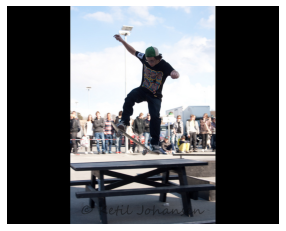

QUESTION
what is he on top of
MOST COMMON ANSWER
picnic table
PREDICTED ANSWER
yes


In [26]:
print_item_pred(data, model, [262148002], False)

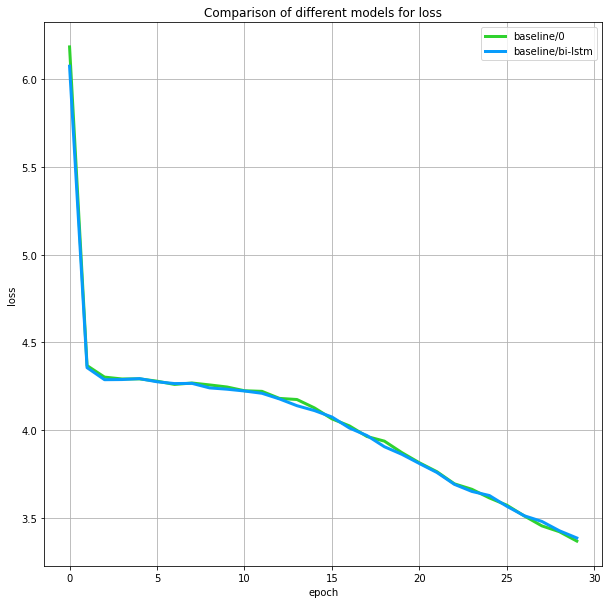

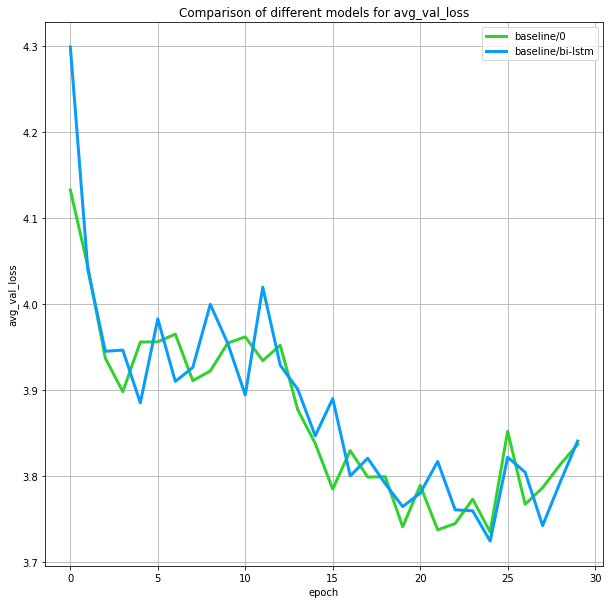

In [27]:
models_name = ["baseline/0", "baseline/bi-lstm"]
metrics = ["loss", "avg_val_loss"]
md = plot_multiple(metrics, models_name)

#### **Conclusions**

As shown from the evaluation this model achieves a final accuracy of **27%** on the validation set. By looking carefully the results we can see how only answers like "yes/no" are given correctly (*>65%*) while the performances are heavily penalized by "*other*" and "*number*" question types. Scoring so poorly we tried to improve the language model using a ***Bi-LSTM*** over the simple *LSTM* to attain better performances, but we got the same training trend.



> ❗ *The bottleneck of our network, as one can expect, is the CNN.*


This may not look good but it was actually a real ***breakthrough***. Using *VGG* the model is not able to correctly learn specific features in an image (*for instance to count objects*), but it is able in some cases to answer easy questions which would require a *yes/no* answer. This subproblem can be seen as a classification task that our model is able to solve.


### Intermediate

Before tackling the problem with ***SOTA models*** we wanted to see how the baseline would improve by replacing VGG with a vision transformer (**ViT**), its mechanism will be described with more emphasis later in this notebook. <br> In particular we used "*google/vit-base-patch32-384*" which takes as input images of size **384** and splits them in patches of size **32** for which it will compute the attention. <br> In this (we can say *superclass of the baseline*) we concatenated the language embedding to the mean of the last four hidden layers of ViT. We want to see that even if the transformer is able to use **intra-attention** whithin the patches, it doesn't have any clue about the question before "*inference*" time. 



> This means that it doesn't really know in which region of the image focus the attention to answer and therefore is not really going to be different w.r.t. the baseline.  




In [28]:
class VQA_DatasetInt(Dataset):
    def __init__(self, VQA, qv_w2id, av_w2id):
        self.data = self.make_data(VQA, qv_w2id, av_w2id)

    def make_data(self, VQA, qv_w2id, av_w2id):
        data = list()
        qv_l = len(qv_w2id.keys())-2
        av_l = len(av_w2id.keys())-2
        imgs = dict()
        for k in VQA.qa:
            item = dict()
            item["id"] = k
            item["question"] = [qv_w2id.get(w, qv_l)
                                for w in VQA.qqa[k]['question'].split()]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            # note the difference here in resizing the image
            imgs[img_id] = imgs.get(img_id, Image.open(
                img_pth).convert('RGB').resize((384, 384)))
            item["img"] = imgs[img_id]
            item["answer"] = av_w2id.get(
                VQA.qa[k]["multiple_choice_answer"], av_l)
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class VQA_DataModuleInt(VQA_DataModule):
    def __init__(
            self, hparams: dict, train_VQA: Any, val_VQA: Any, qv_w2id: dict,
            qv_id2w: dict, av_w2id: dict, av_id2w: dict) -> None:
        super(VQA_DataModuleInt, self).__init__(
            hparams, train_VQA, val_VQA, qv_w2id, qv_id2w, av_w2id, av_id2w)

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_DatasetInt(
            self.train_VQA, self.qv_w2id, self.av_w2id)
        self.data_val = VQA_DatasetInt(
            self.val_VQA, self.qv_w2id, self.av_w2id)

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        batch_out["img"] = [sample["img"] for sample in batch]
        batch_out["question"] = pad_sequence(
            [torch.as_tensor(sample["question"]) for sample in batch],
            batch_first=True,
            padding_value=self.hparams.qv_size+1
        )
        return batch_out

In [29]:
class VQA_Intermediate(VQA_Baseline):
    def __init__(self, hparams: dict):
        super(VQA_Intermediate, self).__init__(hparams)
        del self.cnn
        del self.classifier
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            'google/vit-base-patch32-384')
        m_vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch32-384')
        # we only extract the vit from it
        self.m_vit = m_vit.vit
        for param in self.m_vit.parameters():
            param.requires_grad = False
        if self.hparams.trainable_embeddings:
            unfreeze = [10, 11]
            for i in unfreeze:
                for params in self.m_vit.encoder.layer[i].parameters():
                    params.requires_grad = True
        self.classifier = nn.Linear(
            2*self.hparams.output_dim, self.hparams.av_size)

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        features = self.feature_extractor(
            x["img"],
            return_tensors="pt").to(
            self.device)
        y = self.m_vit(**features)
        img_emb = y.last_hidden_state[:, -4:, :].mean(dim=1)
        t_words = self.word_emb(x["question"])
        _, (h, c) = self.lstm(t_words)
        t_quest_tmp = torch.cat([c, h])
        t_quest = t_quest_tmp.reshape(t_quest_tmp.shape[1], -1)
        qst_emb = self.mlp2(t_quest)
        qq = torch.cat([img_emb, qst_emb], dim=-1)
        q_i_emb = self.dropout(qq)
        return {"class_prob": self.classifier(q_i_emb), "id": x["id"]}

In [30]:
# free ram
del data
del model
gc.collect()

hparams_int = asdict(HParams())
hparams_int["output_dim"] = 768
data = VQA_DataModuleInt(
    hparams_int, train_VQA, val_VQA, qv_w2id, qv_id2w, av_w2id, av_id2w)
model = VQA_Intermediate(hparams_int)

trainer = train_model(
    data, model, experiment_name="baseline", log_version="colab",
    patience=1, metric_to_monitor="avg_val_loss", mode="min", epochs=1)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | mlp1       | Linear    | 3.1 M 
1 | word_emb   | Embedding | 300 K 
2 | lstm       | LSTM      | 3.8 M 
3 | dropout    | Dropout   | 0     
4 | mlp2       | Linear    | 1.6 M 
5 | m_vit      | ViTModel  | 87.5 M
6 | classifier | Linear    | 1.5 M 
-----------------------------------------
24.5 M    Trainable params
73.4 M    Non-trainable params
97.9 M    Total params
391.417   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 41/41 [01:30<00:00,  2.21s/it, loss=4.34, v_num=olab]

Metric avg_val_loss improved. New best score: 3.713


Epoch 0: 100%|██████████| 41/41 [01:30<00:00,  2.21s/it, loss=4.34, v_num=olab]

Epoch 0, global step 37: 'avg_val_loss' reached 3.71258 (best 3.71258), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/baseline_colab-epoch=00-avg_val_loss=3.7126.ckpt' as top 1


Epoch 0: 100%|██████████| 41/41 [01:31<00:00,  2.23s/it, loss=4.34, v_num=olab]


In [31]:
# free ram
del model
gc.collect()

best_ckpt = "models/Intermediate_1-epoch=91-loss=1.6212.ckpt"
model = VQA_Intermediate.load_from_checkpoint(best_ckpt, strict=True)
ans_types, scores = evaluate_performances(model, data,
                                          need_device=False,
                                          on_train_set=True,
                                          intermediate=True)
ans_typesv, scoresv = evaluate_performances(model, data,
                                            need_device=False,
                                            on_train_set=False,
                                            intermediate=True)

100%|██████████| 37/37 [01:38<00:00,  2.66s/it]


There are: (type, number)
yes/no 3675
with score: 0.6969614512471657
other 4337
with score: 0.16286219352855283
number 1259
with score: 0.23881387344453275
Final score: 0.3848919569985259


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]

There are: (type, number)
other 465
with score: 0.01935483870967742
yes/no 412
with score: 0.6213592233009712
number 123
with score: 0.0
Final score: 0.2650000000000001


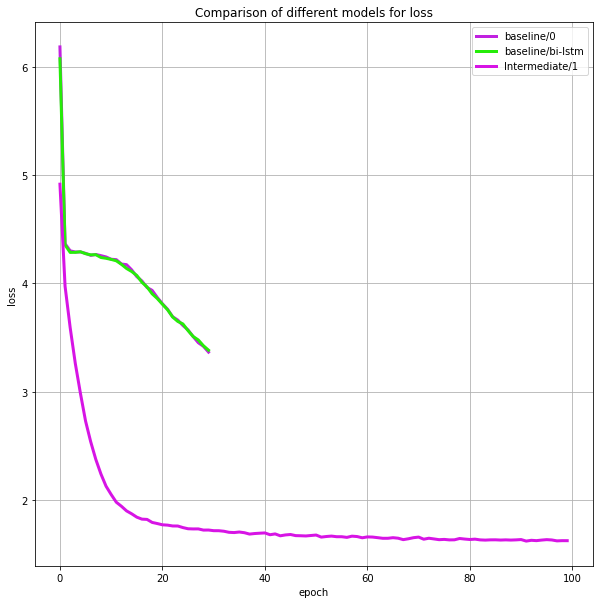

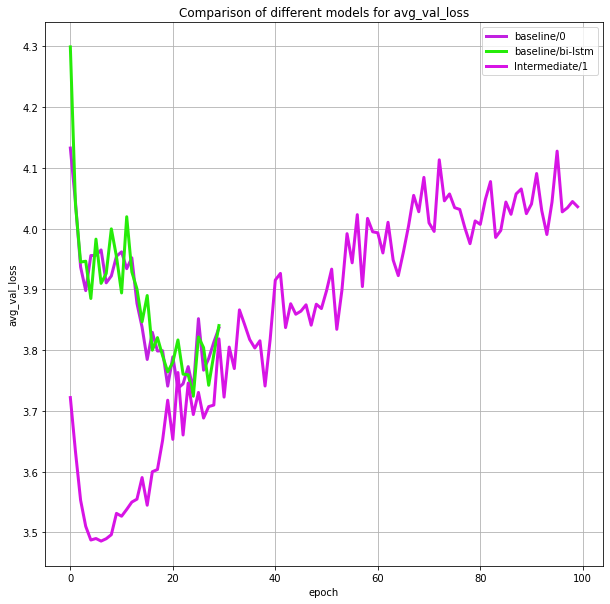

In [32]:
models_name = ["baseline/0", "baseline/bi-lstm", "Intermediate/1"]
metrics = ["loss", "avg_val_loss"]
md = plot_multiple(metrics, models_name)

#### **Results**
As expected the results are slightly better then the one obtained in the *baseline*. It is interesting to notice that with this *patching approach* the model **overfits** the training dataset and therefore has a much higher score with respect to the baseline there, but once we evaluate the model using validation set,  performances drop drastically, with an accuracy of **0%** when there is need to count. It confirms our thesis about the *inter-attention*.

> 🔸 *How can improve this model by giving it the capability to pose attention on a given question regarding an image?* <br>
**Answer is below !**


### **ViLT**: *Vision-and-Language Transformer model*

As discussed the **VGG** or, in general any **CNN**, is too simple to capture the features needed to properly answer a question that does not require a yes/no answer. Moreover, even using **transformers** if we treat the image and language stream independently we cannot aim for the stars. <br> For this reason we switched to an higher capacitive model that makes those two representation interact, in particular the ***Vision and Language Transformers***, so that from one side we can better embed the question sentence avoiding a randomly initialized "*nn.embedder*" and from the other, and this is very important, our model can reason on different patches of the image and point the correct attention to the meaningful features that allows to answer correctly by a ***Modality Iteraction***. <br> 
<br>
<img src='https://i.imgur.com/SI9t9BD.png'>
<br>
First of all there are different *modalities* to extract significant patches from the image:
* *Region features*: also known as bottom-up features are intensively used by VLP models *before 2020*. They are obtained from an object detector like **Faster R-CNN**. This approach is very slow and constitute a bottleneck in the inference algorithm since requires many steps of refinements in order to produce those features. 


  > One famous architecture that exploit those features is ***LXMERT*** https://arxiv.org/pdf/1908.07490.pdf, professor suggested this one but either due to slowness and computational resources we left behind this idea.


* *Grid Feature*: the idea is to exploit *output feature* grid of CNNs such as **ResNets**. It's surely faster to extract them, nevertheless deep CNNs are still expensive and they account for a large portion of the whole computation. Still those features are ~40 times faster to compute with respect to "*region features*", and indeed many VQA models have been built exploiting them, the most popular are ***X-LXMERT*** and ***Pixel-BERT***.
* **Patch Projection**: is the simplest visual embedding scheme, indeed only a linear projection operates on image patches. It drastically simplifies the visual embedding step to the level of textual embedding, which also consists of simple projection (lookup) operations. **Simplicity** implies also **velocity** in this case, those are also the fastest features to use ~4 times faster than "Grid" ones. <br>Nowadays when one talk about *Vision Transformers (ViT) thinks about this strategy.*


For our model we decided to adopt the ***ViLT*** base https://arxiv.org/abs/2102.03334 that uses **ViT-B/32** (and therefore the *patch projection*) as vision model and the good old **BERT** as *language model*. <br> **ViT** consists of stacked blocks that include a *multiheaded self-attention* (**MSA**) layer and an **MLP** layer. The position of layer normalization (**LN**) in ViT is the only difference from BERT. <br>



> We used as pre-trained model "*dandelin/vilt-b32-finetuned-vqa*" from *Hugging Face* which has been pretrained on a **VQA task** and huge amount of data. Then, due to our hardware limits and remarkable studies like https://arxiv.org/abs/1905.05583, we decided to fine-tune only the last **2** embedding layers! 



***ViLT*** benefits from both "*Single-Modality*" and "*Cross-Modality*" which are nothing else than the *attention mechanism* between only the vision and language model and across them to predict the final answer's class. 
<img src='https://i.imgur.com/OL4GoZA.png'><br>
The above figure summarize the whole architecture on which we've built upon a *MLP* to final predict the answer. Some enthralling aspects is that to properly let the network differentiate images and words embedding is to concatenate to the embedding special **modal-type tokens**. <br> The *pretraining-objectives* to which the model owes its strength are: **Image Text Matching** (which exploit contrastive learning to replace the *aligned image* with a different image with the probability *0.5* and word patch alignment using subsets of words and patches), **Masked Language Modeling** (instead of predicting every next token, a percentage of input tokens is masked at random and only those masked tokens are predicted). 


> 💡 Those are key aspects because permit this model to implicitly learn the ***Modality Interaction*** (or *cross attention*), that is essential for VQA task as we had explored in the intermediate experiment.



We decided to define another class of **hyperparameters** to simplify the run of the experiments testing our ***new proposed variations*** with respect to the original paper.

In [33]:
@dataclass
class HParams2():
    # dataset stuff
    batch_size: int = 256
    n_cpu: int = 8 if local_project else 2
    qv_size: int = 1000 #+1 for oov +1 for pad
    av_size: int = 1000 #+1 for oov +1 for pad
    lr: int = 3e-4
    wd: int = 0
    dropout: float = 0.3
    trainable_embeddings: bool = True
    #OUR VARIATIONS
    # choose the number of k to use a top-k prediction method
    prediction_strategy_top: int = 1 
    # choose between "simple" and "with_type"
    embedding_strategy: str = "simple" 
    # choose between "simple" and "human_like1" and "human_like2"
    loss_strategy: str = "simple" 

We need to slightly modify the dataset in such a way that the input is coherent for the new *ViLT model*: therefore we are not converting to *tensor* the image and *embed* the question but let the transformer's ***preprocessor*** doing the job.

In [34]:
class VQA_Dataset2(Dataset):
    def __init__(self, VQA, av_w2id, embedding_strategy, loss_strategy):
        assert (embedding_strategy in ["simple", "with_type"])
        assert (loss_strategy in ["simple", "human_like1", "human_like2"])
        self.data = self.make_data(
            VQA, av_w2id, embedding_strategy, loss_strategy)

    def make_data(self, VQA, av_w2id, embedding_strategy, loss_strategy):
        data = list()
        av_l = len(av_w2id.keys())-2
        imgs = dict()
        for k in VQA.qa:
            item = dict()
            item["id"] = k
            if embedding_strategy == "simple":
                item["question"] = VQA.qqa[k]['question']
            else:
                # we now embed together with the question, as "context" for
                # the bert model inside ViLT, the "question_type" word, the
                # idea is that with this helpful information the language
                # embedder can point the attention to meaningful keywords
                # like ["how" "many" ... "dogs"] insie a "number-type" question.
                item["question"] = [
                    VQA.qqa[k]['question'],
                    VQA.qa[k]["answer_type"]]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            imgs[img_id] = imgs.get(img_id, Image.open(img_pth).convert('RGB'))
            item["img"] = imgs[img_id]
            if loss_strategy != "simple":
                item["all_answers"] = [av_w2id.get(
                    ans["answer"], av_l) for ans in VQA.qa[k]["answers"]]
            item["answer"] = av_w2id.get(
                VQA.qa[k]["multiple_choice_answer"], av_l)
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class VQA_DataModule2(pl.LightningDataModule):
    def __init__(self, hparams: dict, train_VQA: Any, val_VQA: Any,
                 av_w2id: dict, av_id2w: dict) -> None:
        super().__init__()
        self.save_hyperparameters(hparams)
        self.train_VQA = train_VQA
        self.val_VQA = val_VQA
        self.av_w2id = av_w2id
        self.av_id2w = av_id2w

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_Dataset2(
            self.train_VQA, self.av_w2id, self.hparams.embedding_strategy,
            self.hparams.loss_strategy)
        self.data_val = VQA_Dataset2(
             self.val_VQA, self.av_w2id,
             self.hparams.embedding_strategy,self.hparams.loss_strategy)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=local_project,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=local_project,
            persistent_workers=True
        )

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        if self.hparams.loss_strategy != "simple":
            batch_out["all_answers"] = [sample["all_answers"]
                                        for sample in batch]
        batch_out["img"] = [sample["img"] for sample in batch]
        batch_out["question"] = [sample["question"] for sample in batch]
        return batch_out


In [35]:
class VQA_ViLT(pl.LightningModule):
    def __init__(self, hparams: dict) -> None:
        super(VQA_ViLT, self).__init__()
        self.save_hyperparameters(hparams)
        self.processor = ViltProcessor.from_pretrained(
            "dandelin/vilt-b32-finetuned-vqa")
        self.vilt = ViltModel.from_pretrained(
            "dandelin/vilt-b32-finetuned-vqa")
        for param in self.vilt.parameters():
            param.requires_grad = False
        if self.hparams.trainable_embeddings:
            #we can unfreeze only some layers due to limited gpu card memory.
            unfreeze = [10, 11]
            for i in unfreeze:
                for param in self.vilt.encoder.layer[i].parameters():
                    param.requires_grad = True
        self.dropout = nn.Dropout(self.hparams.dropout)
        self.classifier = nn.Sequential(
            nn.Linear(768, 1500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1500, self.hparams.av_size),
            nn.LeakyReLU())
        # self.classifier = nn.Linear(768, self.hparams.av_size)

    def forward(self, x):
        embeddings = self.processor(
            x["img"],
            x["question"],
            return_tensors="pt", padding=True).to(self.device)
        o = self.vilt(**embeddings).pooler_output
        if self.hparams.loss_strategy == "simple":
            return {"class_prob": self.classifier(self.dropout(o)),
                    "id": x["id"]}
        else:
            return {"class_prob": self.classifier(self.dropout(o)),
                    "id": x["id"], "all_answers": x["all_answers"]}

    def predict(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        n_out = dict()
        self.eval()
        with torch.no_grad():
            output = self(x)
            # here we implement a top k prediction strategy with
            # a given k as hyperparameter if k = 1 we are simply 
            # using the argmax prediction as in the baseline
            top_k = torch.topk(
                output["class_prob"],
                self.hparams.prediction_strategy_top, dim=-1)
            # we need to normalize the "probabilities" (this step is
            # not done at prediction time because it is implicit in the
            # crossentropy function, still we need to manually apply 
            # it here)
            scores = F.softmax(top_k.values, dim=-1)
            # we sample only one element from the given
            # "probability distribution" extracted with topk
            pred_id = torch.multinomial(scores, 1).view(-1).tolist()
            pred = top_k.indices[torch.arange(top_k.indices.size(0)), pred_id]
            n_out["pred"] = pred.view(-1).tolist()
            n_out["id"] = output["id"]
        return n_out

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr, betas=(0.9, 0.999),
            eps=1e-6, weight_decay=self.hparams.wd)
        reduce_lr_on_plateau = ReduceLROnPlateau(
            optimizer, mode='min', verbose=True, min_lr=1e-8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": reduce_lr_on_plateau,
                "monitor": 'loss',
                "frequency": 1
            },
        }

    def training_step(self, batch: Dict[str, torch.Tensor],
                      batch_idx) -> Dict[str, torch.Tensor]:
        output = self(batch)
        return self.loss_function(output, batch["answer"])

    def validation_step(self, batch: Dict[str, torch.Tensor],
                        batch_idx: int) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        return {"loss_val": loss}

    def loss_function(self, predictions, labels):
        pred, lab = predictions["class_prob"], labels
        splits = self.hparams.loss_strategy.split("human_like")
        if len(splits) > 1 and self.training:
            answers = torch.as_tensor(predictions["all_answers"]).to(self.device)
            most_prob = torch.argmax(predictions["class_prob"], dim=1).view(-1)
            filter = most_prob.unsqueeze(dim=1) == answers
            filter = torch.sum(filter.float(), dim=1)
            filter = filter < int(splits[1])
            # if we have at least one answer inside the
            # possible proposed by humans we accept it as
            # valid answer, and so we do not care about its loss!
            if not torch.all(filter == False):
                pred, lab = predictions["class_prob"][filter], labels[filter]
            else:
                print("our training is considered complete for this batch")
                # with None we skip this training step
                return None
        return F.cross_entropy(
            pred, lab, ignore_index=self.hparams.av_size)

    def validation_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss_val"] for x in outputs]).mean()
        self.log_dict({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss}

    def training_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log_dict({"loss": avg_loss})


In [36]:
# free ram
del data
del model
gc.collect()

hparams2 = asdict(HParams2())
# choose the number of k to use a top-k prediction method
hparams2["prediction_strategy_top"] = 1 
# choose between "simple" and "with_type"
hparams2["embedding_strategy"] = "with_type" 
# choose between "simple" and "human_like1" and "human_like2"
hparams2["loss_strategy"] = "human_like1" 
data = VQA_DataModule2(hparams2, train_VQA, val_VQA, av_w2id, av_id2w)
model = VQA_ViLT(hparams2)

trainer_int = train_model(
    data, model, experiment_name="ViLT", log_version="colab",
    patience=1, metric_to_monitor="avg_val_loss", mode="min", epochs=1)

Some weights of the model checkpoint at dandelin/vilt-b32-finetuned-vqa were not used when initializing ViltModel: ['classifier.1.bias', 'classifier.0.bias', 'classifier.3.weight', 'classifier.1.weight', 'classifier.3.bias', 'classifier.0.weight']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | vilt       | ViltModel  | 1

Epoch 0: 100%|██████████| 41/41 [03:42<00:00,  5.44s/it, loss=5.76, v_num=olab]

Metric avg_val_loss improved. New best score: 2.588


Epoch 0: 100%|██████████| 41/41 [03:42<00:00,  5.44s/it, loss=5.76, v_num=olab]

Epoch 0, global step 37: 'avg_val_loss' reached 2.58771 (best 2.58771), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/ViLT_colab-epoch=00-avg_val_loss=2.5877.ckpt' as top 1


Epoch 0: 100%|██████████| 41/41 [03:43<00:00,  5.46s/it, loss=5.76, v_num=olab]


#### Evaluation and prediction examples

In [40]:
# free ram
del model
gc.collect()

best_ckpt = "models/ViLT_ex7_with_type_humanlike1_top1-epoch=" + \
            "18-avg_val_loss=1.2612.ckpt"
model = VQA_ViLT.load_from_checkpoint(best_ckpt, strict=True)
ans_types2, scores2 = evaluate_performances(
    model, data, on_train_set=False, need_device=False)

Some weights of the model checkpoint at dandelin/vilt-b32-finetuned-vqa were not used when initializing ViltModel: ['classifier.1.bias', 'classifier.0.bias', 'classifier.3.weight', 'classifier.1.weight', 'classifier.3.bias', 'classifier.0.weight']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:22<00:00,  5.66s/it]


There are: (type, number)
other 465
with score: 0.5111111111111112
yes/no 412
with score: 0.9037216828478962
number 123
with score: 0.5636856368563687
Final score: 0.6793333333333333


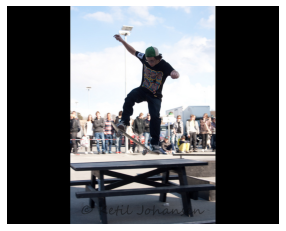

QUESTION
what is he on top of
MOST COMMON ANSWER
picnic table
PREDICTED ANSWER
bench


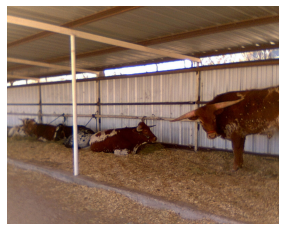

QUESTION
why is there  gap between  roof and wall
MOST COMMON ANSWER
yes
PREDICTED ANSWER
yes


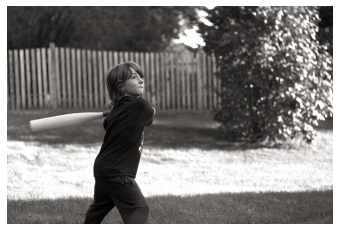

QUESTION
how many are playing ball
MOST COMMON ANSWER
1
PREDICTED ANSWER
1


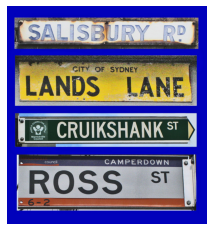

QUESTION
what color is  salisbury rd sign
MOST COMMON ANSWER
white
PREDICTED ANSWER
white


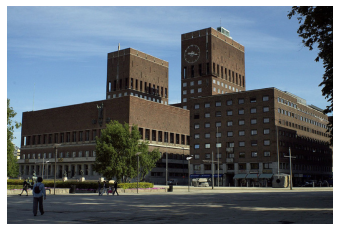

QUESTION
is there  person riding  bike
MOST COMMON ANSWER
no
PREDICTED ANSWER
no


In [41]:
print_item_pred(data, model, [262197003,131089002,262148002,262189001,240301000]
                , on_train_set=False, need_device=False)

Here we've collected some answers from the validation-set, what we think it's interesting are not only correct answers but much more the first example where the model predicted "bench" and the right answer was "picnic table", now you can think *- ok one could get confused by a picnic table and a bench -* but what we want to ***underline*** is that in no way our model could have predicted "picnic table" simply because we are working with mono-word answers so it's fascinating that he found the mono-word answer that most plausible as the ground truth. In the second example instead we got a correct answer "yes" but look at the most common does it make sense to you answer "yes" to a "why" question? Clearly it is an error in the data and for this reason human-like approach we invented is not a stupid. Indeed in the dataset if you look careful there is a proposed answer that seems to be the right one "(for) air", this to stress that datasets are made by human and human do mistakes so a little bias there could be everywhere!!

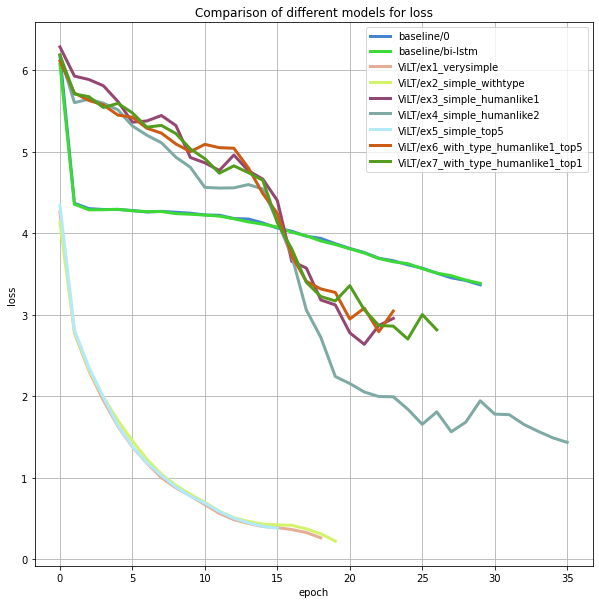

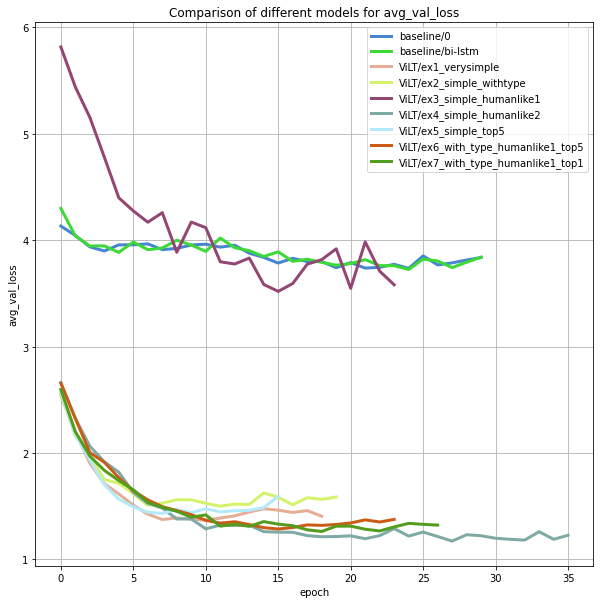

In [42]:
models_name = [
    "baseline/0", "baseline/bi-lstm", "ViLT/ex1_verysimple",
    "ViLT/ex2_simple_withtype", "ViLT/ex3_simple_humanlike1",
    "ViLT/ex4_simple_humanlike2", "ViLT/ex5_simple_top5",
    "ViLT/ex6_with_type_humanlike1_top5" ,"ViLT/ex7_with_type_humanlike1_top1"]
metrics = ["loss", "avg_val_loss"]
md = plot_multiple(metrics, models_name)

#### **Final results**



> Here we report the *final table* with the **results** and the ***experiments*** that we have done with the different configurations.

*  ***Top k*** gives an information regarding the number of final possible answers from which we draw according to their probability (*top k=1 it's the typical argmax approach*). 
*  ***Embedding*** has the two options "*simple*" and "*with type*", in the latter case also the type of the question is used to help the network in the prediction. 
*  ***Loss*** can be either "*simple*" or "*human like*". In *human like* case the idea is to accept a prediction if it's present in the dataset answer pool.

<br>
<table>
  <tr>
    <th><center>experiment</center></th>
    <th><center>top k</center></th>
    <th><center>embedding</center></th>
    <th><center>loss</center></th>
    <th><center>yes/no</center></th>
    <th><center>other</center></th>
    <th><center>number</center></th>
    <th><center>final</center></th>
  </tr>
  <tr>
    <td><center>1</center></td>
    <td><center>top 1</center></td>
    <td><center>simple</center></td>
    <td><center>simple</center></td>
    <th><center>92.5%</center></th>
    <td><center>50.0%</center></td>
    <td><center>47.1%</center></td>
    <td><center>67.2%</center></td>
  </tr>
    <tr>
    <td><center>2</center></td>
    <td><center>top 1</center></td>
    <td><center>with_type</center></td>
    <td><center>simple</center></td>
    <td><center>92.3%</center></td>
    <td><center>48.2%</center></td>
    <th><center>58.8%</center></th>
    <th><center>67.7%</center></th>
  </tr>
    <tr>
    <td><center>3</center></td>
    <td><center>top 1</center></td>
    <td><center>simple</center></td>
    <td><center>human_like1</center></td>
    <td><center>90.0%</center></td>
    <td><center>47.2%</center></td>
    <td><center>45.2%</center></td>
    <td><center>64.6%</center></td>
  </tr>
    <tr>
    <td><center>4</center></td>
    <td><center>top 1</center></td>
    <td><center>simple</center></td>
    <td><center>human_like2</center></td>
    <td><center>90.4%</center></td>
    <td><center>45.9%</center></td>
    <td><center>52.5%</center></td>
    <td><center>65.1%</center></td>
  </tr>
   <tr>
    <td><center>5</center></td>
    <td><center>top 1</center></td>
    <td><center>with_type</center></td>
    <td><center>human_like1</center></td>
    <td><center>90.6%</center></td>
    <th><center>50.4%</center></th>
    <td><center>52.3%</center></td>
    <td><center>67.2%</center></td>
  </tr>
    <tr>
    <td><center>6</center></td>
    <td><center>top 5</center></td>
    <td><center>simple</center></td>
    <td><center>simple</center></td>
    <td><center>89.7%</center></td>
    <td><center>42.4%</center></td>
    <td><center>53.3%</center></td>
    <td><center>63.2%</center></td>
  </tr>
    <tr>
    <td><center>7</center></td>
    <td><center>top 5</center></td>
    <td><center>with_type</center></td>
    <td><center>human_like1</center></td>
    <td><center>85.2%</center></td>
    <td><center>42.2%</center></td>
    <td><center>42.8%</center></td>
    <td><center>60.0%</center></td>
  </tr>
 

</table>
<br>

- The *first experiment* employes the standard methodology and will be used to compare the other results. Our aim is to perform better than it. We should notice that it reaches a *good final accuracy* per se.

- The second experiment confirms our **intuitions**: *by giving also the **context** we are able to (slightly) improve the network performances*. This is because we are leading the model to filter between all the possible answers and focusing its attention to those features that are commonly required to infer the output.

> 💡 Notice that one could've instead expectected that given the fact that we are also providing expected answer type (question type) the model is driven to the solution putting less effort in understanding the question and then the associated image.

- **Human like** experiments didn't bring astonishing results, still this is a technique that strongly **reduce overfitting** since it stops the propagation of the gradients for those answers' samples which are plausible because given as a reply by a human (*1 or 2 times depending on the chosen loss strategy*).

- Lastly we decided to follow the professor advice of using a **top k prediction strategy** and in those experiments (*unlikely*) we got the worst results. In our opinion this strategy is really helpful when the model is slightly confused about the answer as may happen in the counting task. Indeed from the *table* we can see that ***experiment 1*** and ***experiment 6*** has an improvement of **6.2%** in the *number prediction* but worsen in the others. 



